# Indlæser pakker

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from pathlib import Path # To make relative paths
import plotly.express as px
pd.options.display.max_columns = None
import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'browser'  # or 'browser', 'notebook_connected', etc., depending on your environment

px.set_mapbox_access_token('your_mapbox_access_token_here')

import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import statistics as stat
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)



# Sætter paths

In [2]:
my_path = Path.cwd() # Path to current directory
project_path = my_path.parents[0] # Path to project directory
data_path = project_path / 'Data' # Path to data folder
data_path

WindowsPath('C:/Users/nld/Introduction to Data Science/Exam Project/Data')

# Indlæser data

In [83]:
# Samlet data
final_df = pd.read_parquet(data_path/'ML_Dataset.parquet', engine='pyarrow')

# ML

## Klargør data til ML

In [84]:
# Dividerer pris med 1 mio.
final_df['priceMil'] = final_df['priceCash']/1000000

In [98]:
# Udvælger variable
model_df = final_df[['priceMil', 'job_density', 'distance_to_nearest_station', 'departures_per_hour', 
                    'distance_to_job_center', 'propertyType', 'energyClass', 
                     'rooms', 'size', 'lotSize', 'basementSize', 'exp',
                   'buildYear', 
                     'municipality']].reset_index(drop=True)

In [99]:
# Make dummy variables
# Create dummy variables for propertyType, energyClass, and area
model_df_dummies = pd.get_dummies(model_df, columns=['propertyType', 'energyClass', 'municipality'], drop_first=True)

In [101]:
# Define x and y variables
X = model_df_dummies.drop('priceMil', axis=1)  # Features (drop the target variable)
y = model_df_dummies['priceMil']               # Target variable

Index(['job_density', 'distance_to_nearest_station', 'departures_per_hour',
       'distance_to_job_center', 'rooms', 'size', 'lotSize', 'basementSize',
       'exp', 'buildYear',
       ...
       'municipality_791.0', 'municipality_810.0', 'municipality_813.0',
       'municipality_820.0', 'municipality_825.0', 'municipality_840.0',
       'municipality_846.0', 'municipality_849.0', 'municipality_851.0',
       'municipality_860.0'],
      dtype='object', length=122)

In [89]:
# 1. Split data data into development and test
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)

In [90]:
X_dev = X_dev.reset_index(drop = True)
y_dev = y_dev.reset_index(drop = True)


## LASSO

In [94]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=2)
folds = list(kfolds.split(X_dev, y_dev))
folds

# Define lambds
lambdas =  np.logspace(-4, 4, 12)

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        # Make pipeline
        pipe_lasso = make_pipeline(PolynomialFeatures(degree = 2, include_bias=False),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=161193))   
        # Split development data into training and validation data
        X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 
        
        # Train the model using pipe_lasso
        pipe_lasso.fit(X_train, y_train)
        
        # Calculate MSE for validation data
        mseCV_.append(mse(pipe_lasso.predict(X_val), y_val))    
        print(mseCV_)
    
    # Calculate average mean squared error in validation data
    avg_mse = stat.mean(mseCV_) 

    # Store result    
    mseCV.append(avg_mse) 
    


[6.253951989293123]
[6.253951989293123, 8.174921492890059]
[5.04907801506138]
[5.04907801506138, 7.647996555565021]
[4.04731295238682]
[4.04731295238682, 5.313900419231829]
[3.829401734257237]
[3.829401734257237, 4.533756866534232]
[4.649052615845205]
[4.649052615845205, 5.0811967838667575]
[5.859676662699008]
[5.859676662699008, 7.20874697192688]
[12.488078492894525]
[12.488078492894525, 13.956862760059712]
[12.488078492894525]
[12.488078492894525, 13.956862760059712]
[12.488078492894525]
[12.488078492894525, 13.956862760059712]
[12.488078492894525]
[12.488078492894525, 13.956862760059712]
[12.488078492894525]
[12.488078492894525, 13.956862760059712]
[12.488078492894525]
[12.488078492894525, 13.956862760059712]


In [97]:
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)
lambdaCV

# Find the index of the minimum RMSE for the test set
min_mse_val_index = np.argmin(mseCV)

# Find the corresponding lambda value
optimal_lambda = lambdas[min_mse_val_index]

# Find the corresponding minimum RMSE value
min_mse_val = mseCV[min_mse_val_index]

print(f"The optimal lambda (alpha) that gives the lowest test AMSE is: {optimal_lambda}")
print(f"The lowest test AMSE is: {min_mse_val}")
lambdaCV

The optimal lambda (alpha) that gives the lowest test AMSE is: 0.01519911082952933
The lowest test AMSE is: 4.181579300395734


,0
0.000100,7.214437
0.000534,6.348537
0.002848,4.680607
0.015199,4.181579
0.081113,4.865125
0.432876,6.534212
2.310130,13.222471
12.328467,13.222471
65.793322,13.222471
351.119173,13.222471


In [102]:
# LOAD FROM SCIKIT-LEARN
from sklearn.model_selection import validation_curve

# Define lambds
lambdas =  np.logspace(-4, 4, 12)

# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=2)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

# YAY we get the same result as in the previous excercise

lambda
0.015199    4.181579
Name: Validation, dtype: float64


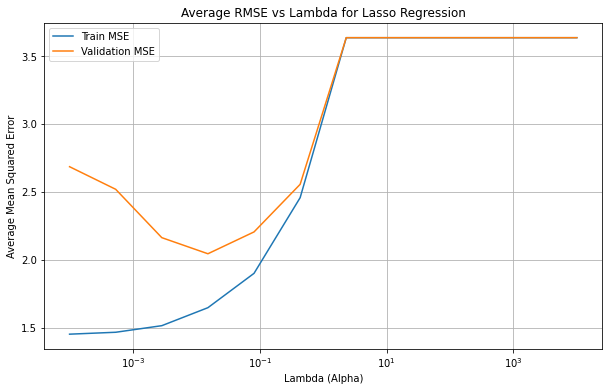

In [119]:
# Plot average MSE for train and test data against different values of lambda
plt.figure(figsize=(10, 6))
plt.plot(lambdas, np.sqrt(mse_score['Train']), label='Train MSE')
plt.plot(lambdas, np.sqrt(mse_score['Validation']), label='Validation MSE')
plt.xscale('log')
plt.xlabel('Lambda (Alpha)')
plt.ylabel('Average Mean Squared Error')
plt.title('Average RMSE vs Lambda for Lasso Regression')
plt.legend()
plt.grid(True)

In [104]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Suppose you have chosen a specific lambda value from the mse_score DataFrame
chosen_lambda = mse_score.Validation.idxmin()  # Selects the lambda with the smallest validation error

# Recreate the pipeline (if not already defined)
pipe_lasso = make_pipeline(PolynomialFeatures(degree = 2, include_bias=False),
                                     StandardScaler(),
                                     Lasso(alpha=chosen_lambda, random_state=161193))   

# Fit the model on the entire development set (or a training set)
pipe_lasso.fit(X_dev, y_dev)

# Access the coefficients (beta parameters)
beta_parameters = pipe_lasso.named_steps['lasso'].coef_

# Optionally, you can also access the intercept
intercept = pipe_lasso.named_steps['lasso'].intercept_

print("Beta coefficients:", beta_parameters)
print("Intercept:", intercept)


Beta coefficients: [ 0. -0.  0. ...  0.  0. -0.]
Intercept: 3.086554841353516


In [118]:
#  Retrieve the feature names from the PolynomialFeatures step
feature_names = pipe_lasso.named_steps['polynomialfeatures'].get_feature_names_out(input_features=X_dev.columns)

# # Identify the non-zero coefficients
non_zero_indices = beta_parameters != 0
non_zero_coefficients = beta_parameters[non_zero_indices]

# Get corresponding feature names for non-zero coefficients
selected_features = feature_names[non_zero_indices]

# Create a DataFrame for easy visualization
non_zero_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': non_zero_coefficients
})

# print(non_zero_df)
non_zero_df.sort_values('Coefficient')

,Feature,Coefficient
290,buildYear municipality_230.0,-0.431723
6,job_density departures_per_hour,-0.430651
16,job_density municipality_157.0,-0.398970
251,basementSize propertyType_3,-0.377399
83,departures_per_hour municipality_157.0,-0.290839
...,...,...
158,size buildYear,0.573807
172,size municipality_157.0,0.710202
7,job_density size,0.858217
182,size municipality_230.0,1.218915


In [130]:
# Create a DataFrame for easy visualization
all_betas = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': beta_parameters
})
all_betas[0:121][all_betas[0:121]['Coefficient']!=0]

,Feature,Coefficient
6,lotSize,0.176418
23,energyClass_F,-0.079420
39,municipality_185.0,0.007145
45,municipality_219.0,0.025000
94,municipality_665.0,-0.000079
105,municipality_756.0,-0.017397
